In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint, choice, seed, random, sample
from copy import deepcopy
import math

# Puzzle

## Game

In [2]:
class Pad:
    def __init__(self):
        self.board = np.zeros((3, 3))

        index = 0
        for i in range(3):
            for j in range(3):
                self.board[i, j] = index
                index += 1

    def swap(self, a, b):
        self.board[a], self.board[b] = self.board[b], self.board[a]

    def move_left(self):
        index = np.where(self.board == 0)
        if index[1] == 2:
            return False
        move_to = (index[0], index[1] + 1)
        self.swap(index, move_to)
        return True

    def move_right(self):
        index = np.where(self.board == 0)
        if index[1] == 0:
            return False
        move_to = (index[0], index[1] - 1)
        self.swap(index, move_to)
        return True

    def move_up(self):
        index = np.where(self.board == 0)
        if index[0] == 2:
            return False
        move_to = (index[0] + 1, index[1])
        self.swap(index, move_to)
        return True

    def move_down(self):
        index = np.where(self.board == 0)
        if index[0] == 0:
            return False
        move_to = (index[0] - 1, index[1])
        self.swap(index, move_to)
        return True

    def __str__(self):
        result = ''
        for i in range(3):
            result += '| '
            for j in range(3):
                number = str(int(self.board[i, j])) if self.board[i, j] != 0 else ' '
                result += f'{number} | '
            result += '\n'
        return result

    def shuffle(self):
        for i in range(randint(10, 100)):
            func = choice([
                self.move_down,
                self.move_up,
                self.move_right,
                self.move_left
            ])
            func()

    def apply_chain(self, chain, with_display=False):
        chain_map = {
            'up': self.move_up,
            'down': self.move_down,
            'left': self.move_left,
            'right': self.move_right,
        }
        for ch in chain:
            chain_map[ch]()
            if with_display:
                print(self)

    def cost(self):
        reference = {
            0: (0, 0),
            1: (0, 1),
            2: (0, 2),

            3: (1, 0),
            4: (1, 1),
            5: (1, 2),

            6: (2, 0),
            7: (2, 1),
            8: (2, 2)
        }

        error = 0.0
        for i in range(9):
            index = np.where(self.board == 1)
            ref_index = reference[i]
            error += (index[0] - ref_index[0]) ** 2 + (index[1] - ref_index[1]) ** 2
        error /= 9.0
        return error[0]

## Chromosome

In [3]:
class Chromosome:
    VALID_MOVES = ['up', 'down', 'left', 'right']

    def __init__(self, puzzle, gene=None):
        self.error = None
        self.error_puzzle_cost = None
        self.error_gene_len = None
        self.puzzle = puzzle
        self.gene = gene if gene else []
        self.update_error()

    def update_error(self):
        temp = deepcopy(self.puzzle)
        temp.apply_chain(self.gene)

        self.error_puzzle_cost = temp.cost()
        self.error_gene_len = len(self.gene) * 0.01
        self.error = self.error_puzzle_cost + self.error_gene_len

    @staticmethod
    def cross_over(a, b):
        if len(b.gene) > len(a.gene):
            return Chromosome.cross_over(b, a)

        geneA = []
        geneB = []
        len_a = len(a.gene)
        len_b = len(b.gene)

        for i in range(len_b):
            if random() < 0.5:
                geneA.append(a.gene[i])
                geneB.append(b.gene[i])
            else:
                geneA.append(b.gene[i])
                geneB.append(a.gene[i])

        if len_b != len_a:
            for i in range(len_a - len_b):
                geneA.append(a.gene[len_b + i])

        return Chromosome(a.puzzle, geneA), Chromosome(b.puzzle, geneB)

    def mutate(self, allow_only_growing=False):
        add_vs_mutate_chance = 0.5 if self.gene else 1.0

        if random() < add_vs_mutate_chance:
            self.gene.append(choice(self.VALID_MOVES))
        else:
            i = randint(0, len(self.gene) - 1)
            self.gene[i] = choice(self.VALID_MOVES)

    def __str__(self):
        return f'({len(self.gene)}) {" -> ".join(self.gene)}'

## Genetic Solver

In [4]:
class GeneticSolver:
    def __init__(self,
                 puzzle,
                 initial_population=1000,
                 mutation_chance=0.9,
                 cross_over_rate=0.3):
        self.puzzle = puzzle

        # parameters
        self.initial_population = initial_population
        self.mutation_chance = mutation_chance
        self.cross_over_rate = cross_over_rate

        # variables
        self.population = []
        self.best = None
        self.error = None
        self.data = {
            'iteration': [],
            'total_error': [],
            'best_solution': [],
            'best_error': []
        }

    def _init_population(self):
        self.population = [Chromosome(puzzle=self.puzzle)
                           for _ in range(self.initial_population)]

    def _calculate_error(self):
        if not self.population:
            return

        if not self.best:
            self.best = self.population[0]

        error = 0
        for chromosome in self.population:
            chromosome.update_error()
            if chromosome.error < self.best.error:
                self.best = deepcopy(chromosome)
            error += chromosome.error
        self.error = error / len(self.population)

    def _select_best(self):
        totals = []
        running_total = 0

        for chromosome in self.population:
            w = 1 / (0.000001 + chromosome.error)
            running_total += w
            totals.append(running_total)

        def select_index():
            rnd = random() * running_total
            for i, total in enumerate(totals):
                if rnd < total:
                    return i

        result = []
        while len(result) < self.initial_population:
            i = select_index()
            result.append(self.population[i])
        self.population = result

    def _cross_over(self, always=False):
        if len(self.population) < 2:
            return

        cross_over_occur = math.ceil(len(self.population) * self.cross_over_rate)
        list_of_fertile_gene = [i for i in range(len(self.population))]

        for i in range(int(cross_over_occur)):
            # parents
            a, b = sample(list_of_fertile_gene, 2)
            for idx, k in enumerate(list_of_fertile_gene):
                if k in (a, b):
                    del list_of_fertile_gene[idx]

            offSpring_a, offSpring_b = Chromosome.cross_over(self.population[a],
                                                             self.population[b])
            minError = min(self.population[a].error, self.population[b].error)
            if (offSpring_a.error < minError and offSpring_b.error < minError) \
                or always:
                    self.population[a] = offSpring_a
                    self.population[b] = offSpring_b

    def _mutate(self):
        for chromosome in self.population:
            if random() < self.mutation_chance:
                chromosome.mutate(True)

    def _display(self, iteration):
        self.data['iteration'].append(iteration)
        self.data['total_error'].append(self.error)
        self.data['best_solution'].append(len(self.best.gene))
        self.data['best_error'].append(self.best.error)

        print(f'Iteration: {iteration}\n' + \
            f'population: len({len(self.population)})\n' + \
            f'Total Error({self.error:0.4f})')

        if self.best:
            print(f'best: {self.best.error:0.4f} -> ' + \
                f'{self.best.error_puzzle_cost:0.4f} + ' + \
                f'{self.best.error_gene_len:0.4f}\n' + \
                f'best is: {self.best}')
        print('\n')

    def solve(self, max_iter=1000, optimal_error=0):
        seed()
        self._init_population()

        iteration = 0
        while iteration < max_iter \
            and (not self.best or self.best.error_puzzle_cost > optimal_error):
            self._cross_over(always=True)
            self._calculate_error()
            self._select_best()
            self._mutate()

            self._display(iteration)
            iteration += 1

        return self.best

## Exercise

In [5]:
puzzle = Pad()
puzzle.shuffle()

solver = GeneticSolver(
    puzzle=puzzle,
    initial_population=500,
    mutation_chance=0.9,
    cross_over_rate=0.4
)
solver.solve(max_iter=20)

print(f'\n\nOriginal:\n{puzzle}\n' + \
    f'Found Solution:\n{solver.best.gene}')

puzzle.apply_chain(solver.best.gene, with_display=True)
print(f'Result:\n{puzzle}')

Iteration: 0
population: len(500)
Total Error(2.3333)
best: 2.3333 -> 2.3333 + 0.0000
best is: (0) 


Iteration: 1
population: len(500)
Total Error(2.5749)
best: 2.3333 -> 2.3333 + 0.0000
best is: (0) 


Iteration: 2
population: len(500)
Total Error(2.6733)
best: 1.3733 -> 1.3333 + 0.0400
best is: (4) up -> right -> left -> down


Iteration: 3
population: len(500)
Total Error(2.7417)
best: 1.3633 -> 1.3333 + 0.0300
best is: (3) up -> left -> down


Iteration: 4
population: len(500)
Total Error(2.6614)
best: 1.3633 -> 1.3333 + 0.0300
best is: (3) up -> left -> down


Iteration: 5
population: len(500)
Total Error(2.6792)
best: 1.3633 -> 1.3333 + 0.0300
best is: (3) up -> left -> down


Iteration: 6
population: len(500)
Total Error(2.6483)
best: 1.3633 -> 1.3333 + 0.0300
best is: (3) up -> left -> down


Iteration: 7
population: len(500)
Total Error(2.6188)
best: 1.3633 -> 1.3333 + 0.0300
best is: (3) up -> left -> down


Iteration: 8
population: len(500)
Total Error(2.6714)
best: 1.3633 

## Analysis of Data

### Total Error

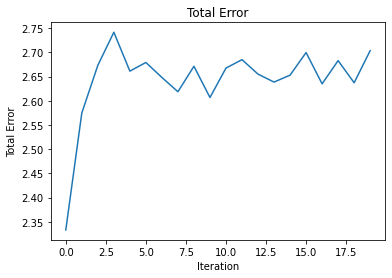

In [6]:
data = solver.data

plt.plot(data['iteration'], data['total_error'])
plt.title('Total Error')
plt.xlabel('Iteration')
plt.ylabel('Total Error')
plt.show()


### Best Solution

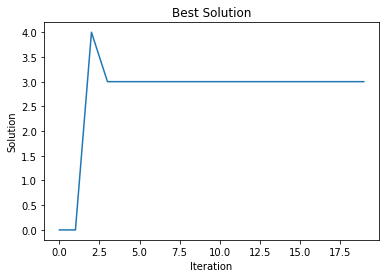

In [7]:
data = solver.data

plt.plot(data['iteration'], data['best_solution'])
plt.title('Best Solution')
plt.xlabel('Iteration')
plt.ylabel('Solution')
plt.show()


### Best Error

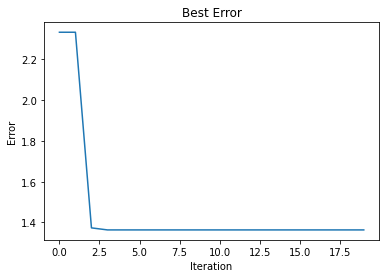

In [8]:
data = solver.data

plt.plot(data['iteration'], data['best_error'])
plt.title('Best Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()
